In [1]:
import ROOT as r
from ROOT.Math import XYZVector
import math
import numpy as np
import os
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.16/00


In [2]:
dataDir = "/mnt/c/users/llave/Documents/CMS/data/"
workDir = "/mnt/c/users/llave/Documents/CMS/work/"
muonDataDir = dataDir + "SingleEle2017F_selection/"
amsbDataDir = dataDir + "AMSB_800GeV_10000cm_selection/"
file = "electronFiducialMap_2017_data.root"

In [4]:
histFile = r.TFile(dataDir+file)
beforeVeto = histFile.Get("beforeVeto_2017F")
afterVeto = histFile.Get("afterVeto_2017F")

In [5]:
mean_ineff = afterVeto.Integral()/beforeVeto.Integral()

nx = beforeVeto.GetNbinsX()
ny = beforeVeto.GetNbinsY()

ineffs = []
sum_ineff=0
for ix in range(nx):
    for iy in range(ny):
        before_bin = beforeVeto.GetBinContent(ix,iy)
        after_bin = afterVeto.GetBinContent(ix,iy)
        if(before_bin == 0): continue
        ineff_bin = after_bin*1.0/before_bin
        ineffs.append(ineff_bin)
        sum_ineff += pow(ineff_bin - mean_ineff,2)
stddev_mean_ineff = math.sqrt(sum_ineff/(nx*ny-1))

print("Found a mean_ineff of",round(mean_ineff,5))
print("Found a stddev_mean_ineff of",round(stddev_mean_ineff,5))

Found a mean_ineff of 0.01947
Found a stddev_mean_ineff of 0.02729


In [6]:
r.gROOT.ProcessLine('.L '+str(workDir)+'Infos.h++')

0

Info in <TUnixSystem::ACLiC>: creating shared library /mnt/c/users/llave/Documents/CMS/work/Infos_h.so


In [3]:
sigma_cuts = np.arange(0,5,0.1)

def calculate_effs(filesDir, sigma_cuts):
    
    overall_eff = []
    for cut in sigma_cuts:
        n_total, n_pass = 0, 0
        for file in os.listdir(filesDir):
            if not("hist" in file and ".root" in file): continue
            dataFile = r.TFile(filesDir+file)
            tree = dataFile.Get("sTree")

            for event in tree:
                for track in event.tracks:
                    n_total +=1
                    momentum = XYZVector(track.px,track.py,track.pz)
                    track_eta = momentum.Eta()
                    track_phi = momentum.Phi()

                    thisBinX, thisBinY = -1,-1
                    for ix in range(nx):
                        found = False
                        if(afterVeto.GetXaxis().GetBinLowEdge(ix) < track_eta):
                            if(ix == nx): found = True
                            if(afterVeto.GetXaxis().GetBinLowEdge(ix+1) > track_eta): found = True
                        if(not found): continue

                        for iy in range(ny):
                            found = False
                            if(afterVeto.GetYaxis().GetBinLowEdge(iy) < track_phi):
                                if(iy == ny): found = True
                                if(afterVeto.GetYaxis().GetBinLowEdge(iy+1) > track_phi): found = True

                            if(found):
                                thisBinX = ix
                                thisBinY = iy

                    before_bin = beforeVeto.GetBinContent(thisBinX,thisBinY)
                    after_bin = afterVeto.GetBinContent(thisBinX,thisBinY)
                    if(before_bin == 0): 
                        n_pass+=1
                        continue
                    this_bin_ineff = after_bin*1.0/before_bin
                    if (this_bin_ineff - mean_ineff) > cut * stddev_mean_ineff:
                        continue
                    else:
                        n_pass+=1

        overall_eff.append(n_pass*1.0/n_total)
    return overall_eff

In [12]:
bkg_effs = calculate_effs(muonDataDir, sigma_cuts)
s_effs = calculate_effs(amsbDataDir, sigma_cuts)

In [4]:
np.save(dataDir+"SingleEle2017F_effs.npy", bkg_effs)
np.save(dataDir+"AMSB_800GeV_10000cm_effs.npy", s_effs)

NameError: name 'bkg_effs' is not defined

In [5]:
bkg_effs = np.load(dataDir+"SingleEle2017F_effs.npy")
s_effs = np.load(dataDir+"AMSB_800GeV_10000cm_effs.npy")

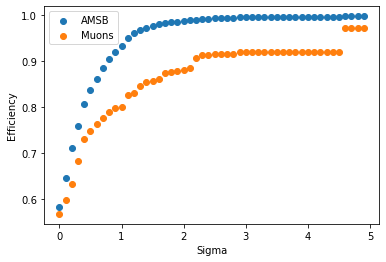

In [8]:
plt.scatter(sigma_cuts,s_effs,label="AMSB")
plt.scatter(sigma_cuts,bkg_effs,label="Muons")
plt.ylabel("Efficiency")
plt.xlabel("Sigma")
plt.legend()

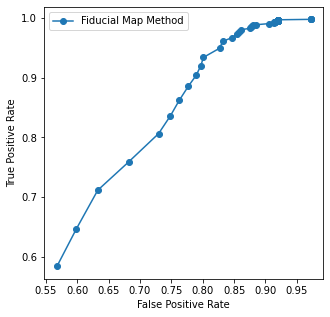

In [9]:
plt.figure(figsize=(5, 5))
plt.plot(bkg_effs, s_effs, '-o', label="Fiducial Map Method")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

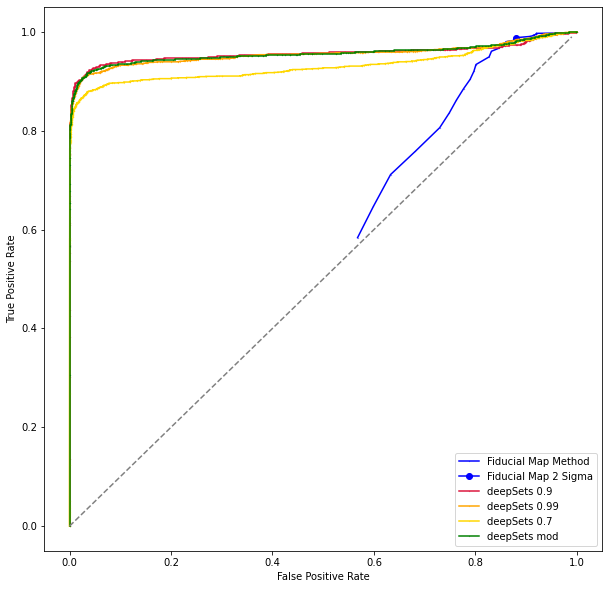

In [6]:
roc = np.load(dataDir+"roc.npz")
tpr = roc['tpr']
fpr = roc['fpr']

roc_0p99 = np.load(dataDir+"roc_0p99.npz")
tpr_0p99 = roc_0p99['tpr']
fpr_0p99 = roc_0p99['fpr']

roc_0p7 = np.load(dataDir+"roc_0p7.npz")
tpr_0p7 = roc_0p7['tpr']
fpr_0p7 = roc_0p7['fpr']

roc_mod = np.load(dataDir+"roc_mod.npz")
tpr_mod = roc_mod['tpr']
fpr_mod = roc_mod['fpr']

plt.figure(figsize=(10, 10))
plt.plot(bkg_effs, s_effs, '-o', markersize = 0.2, color='blue',label="Fiducial Map Method")
plt.plot(bkg_effs[np.where(sigma_cuts == 2.0)], s_effs[np.where(sigma_cuts==2.0)], '-o', color='blue', label="Fiducial Map 2 Sigma")
plt.plot(tpr, fpr, '-o', markersize=0.2, label="deepSets 0.9", color='crimson')
plt.plot(tpr_0p99, fpr_0p99, '-o', markersize=0.2, label="deepSets 0.99", color='orange')
plt.plot(tpr_0p7, fpr_0p7, '-o', markersize=0.2, label="deepSets 0.7", color='gold')
plt.plot(tpr_mod, fpr_mod, '-o', markersize=0.2, label="deepSets mod", color='green')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01), '--', color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [18]:
from sklearn import metrics
auc_0p9 = metrics.auc(tpr, fpr)
auc_0p99 = metrics.auc(tpr_0p99, fpr_0p99)
auc_0p7 = metrics.auc(tpr_0p7, fpr_0p7)
auc_mod = metrics.auc(tpr_mod, fpr_mod)
print(auc_0p9, auc_0p99, auc_0p7, auc_mod)

0.9562180238267994 0.9547707815306676 0.9307112122603446 0.9558270860325454
